<a href="https://colab.research.google.com/github/seldonian-toolkit/Tutorials/blob/main/Tutorial_J_Efficiently_training_deep_Seldonian_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contents
* <a href="#intro">Introduction</a>
* <a href="#outline">Outline of method</a>
* <a href="#example">Example: efficiently training a Seldonian facial recognition system</a>
  * <a href="#prelim">Preliminaries</a>
    * <a href="#cuda">Make sure GPU is enabled with CUDA</a>
    * <a href="#install">Install Seldonian libraries</a>
    * <a href="#imports">Imports</a>
    * <a href="#dataset_prep">Dataset preparation</a>
  * <a href="#step1">Step 1. Split data into two datasets</a>
  * <a href="#step2">Step 2. Train the full network on the candidate data only</a>
  * <a href="#step3">Step 3. Separate out the "body" and the "head" of the full network into two separate models</a>
  * <a href="#step4">Step 4. Assign the weight sfrom the trained full network to the new body-only model</a>
  * <a href="#step5">Step 5. Pass all of the data (both datasets from step 1) through the trained "body-only" model</a>
  * <a href="#step6">Step 6. The head-only model is the model we will use in the toolkit. </a>
  * <a href="#step7">Step 7. The data we will use are the latent features created in step 5. </a>
  * <a href="#step8">Step 8. Assign the `frac_data_in_safety` parameter of the spec object to be the same split fraction as you used in step 1. </a>
  * <a href="#step9">Step 9. Run the Seldonian Engine/Experiments as normal, except now the model is a simple linear model instead of a deep network </a>
  * <a href="#experiments">Run a Seldonian Experiment. </a>


<a name="intro"></a>
# Introduction

Modern deep networks can have billions of trainable parameters, making them computationally expensive to train. Furthermore, hyperparameter tuning usually involves re-training the model many times with different hyperparameters, making it a potential bottleneck in machine learning workflows. In Seldonian algorithms, the addition of constraints increases the computational burden of model training. The number of constraints and the complexity of each constraint will determine how much additional compute is necessary to perform <a href="https://seldonian.cs.umass.edu/Tutorials/tutorials/alg_details_tutorial/#candidate_selection">candidate selection</a>. The toolkit can leverage GPUs when the model is written in PyTorch or Tensorflow to mitigate the computational burden (see <a href="https://seldonian.cs.umass.edu/Tutorials/tutorials/pytorch_mnist/">Tutorial G: Creating your first Seldonian PyTorch model</a>, for example). However, training large models subject to constraints is an unavoidably expensive computation.


The computational burden of candidate selection can be vastly minimized if we simplify the model we need to train subject to the constraints. We hypothesize that most of the hidden layers of a deep learning model can be trained *without* knowledge of the constraints. In general, early layers of a deep network generally learn basic features, and as layer depth increases so does the complexity of the features that are learned. For example, in a convolutional neural network learning to distinguish between images of cats and dogs, the first few layers might learn basic edge filters, and the deeper layers might learn more complex features such as coat patterns and whisker shapes. The final few layers contain the task-specific information that connect the learned features to the output layer. For many types of constraints, it is unlikely that the parameters of the early layers, such as the shape detectors, need to be adjusted to accommodate the constraints. We conjecture that **only the final layer(s) need to be trained in the Seldonian algorithm**, and the rest of the network can be trained in the conventional way without constraints. 

In this tutorial, we formalize the process described above for efficiently training deep networks subject to constraints using the toolkit. We apply this method to the <a href="https://seldonian.cs.umass.edu/Tutorials/examples/facial_recognition/">Gender bias in facial recognition example</a>. We find that using only the final layer in the network when training the Seldonian algorithm, we can achieve equal performance and constraint-satisfaction as we did when using the entire network. 


<a name="outline"></a>
# Outline of method
Here we sketch an outline of the procedure to create efficient deep Seldonian networks by reducing the size of the network that is used in the Seldonian algorithm. The network must be implemented with PyTorch or Tensorflow (or pure Python/NumPy). Note that some steps are to be performed before using the Seldonian Toolkit.


<u>Before using the Seldonian Toolkit:</u>
1. Randomize the data, then split it into two datasets. The optimal split will depend on your specific problem, but we suggest starting with a 50/50 split. 
2. Train the full network on one of these sets using your favorite training method, e.g., <a href="https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop">PyTorch</a>. There is no need to include any information about behavioral constraints in this training process. Save the weights of the trained model so that you can access them again later.
3.  Separate out the "body" and the "head" of the full network into two separate models, a "body-only" model and a "head-only" model. In this tutorial, the head of the network refers to the final fully connected layer (the output layer) of the network. In general, one could split the network anywhere.   
4. Assign the weights from the trained full network to the new body-only model so that this body-only model is "trained." Or, simply remove the head of the full network so that you are left only with the trained body.
5. Pass <i>all</i> of the data (both datasets from step 1) through the trained "body-only" model. Save the outputs of this model. These are your new "latent features" that you will use as input to the Seldonian Toolkit.

<u>Using the Seldonian Toolkit:</u>
6. The head-only model is the model you will use in the toolkit. This head-only model should be initially untrained when used in the toolkit, so don't apply the weights learned in step 2 to the head.
7. The data you will use are the latent features created in step 5. 
8. Assign the `frac_data_in_safety` parameter of the spec object to be the same split fraction as you used in step 1. For example, if you used a 50/50 split, set `frac_data_in_safety=0.5`. It is important that the candidate data you use in the toolkit match the dataset that you used to train the full model in step 2. In other words, <b>no safety data should come from the dataset that was used to train the full model in step 2</b> because that would invalidate the safety/fairness guarantees. The data split that the toolkit performs does not reshuffle the data, so as long as you didn't shuffle the data yourself after step 1 above, this requirement should be met. 
9. Run the Seldonian engine/experiments as normal, except now your model is a simple linear model instead of a deep network. It should be <b>much</b> faster than using the full model as the Seldonian model, especially if your initial network is large.  

<b>Note:</b> if you are starting with a pre-trained network, the steps are slightly different. In this case, you would skip steps 1 and 2. If you have access to the data that was used to train the model, you can use that for candidate selection. However, you must obtain some new data to use for the safety data that was not used to train the pre-trained model. The reason for this is described in step 8. If you do not have access to the data that was used to train the model, then any new data you have can be partitioned into candidate and safety data (via the <code class="highlight">frac_data_in_safety</code> parameter) however you like.

<a name="example"></a>
# Example: Example: efficiently training a Seldonian facial recognition system
We will now go through an example to make the steps described in the outline above more concrete. We will use the same dataset and model from the <a href="https://seldonian.cs.umass.edu/Tutorials/examples/facial_recognition/">Gender bias in facial recognition example</a>. In that example, we trained a convolutional neural network (CNN) to classify gender from images of faces from the UTKFace dataset, subject to a fairness constraint enforcing that accuracy should be similar when predicting male and female faces. Before following along with the steps above, we need to set up our computing environment properly.

<a name="prelim"></a>
## Preliminaries

<a name="cuda"></a>
### Make sure GPU is enabled with CUDA
In the top bar of this Colab, go to Runtime -> Change runtime type and select "GPU" under the hardware accelerator. This will connect you to a new runtime. 

<a name="install"></a>
### Install the Seldonian libraries

In [2]:
!pip install seldonian-experiments==0.0.12

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.2/31.2 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 107.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.1/116.1 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 102.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 KB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 KB 30.0 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.1
    Uninstalling tqdm-4.64.1:
      Successfully uninstalled tqdm-4.64.1
  Attempting uninstall: pl

If a message stating that you must restart the runtime after running the above cell, click the button to restart the runtime. You don't have to re-install the Seldonian libraries, but you will have to run any other code cells again if you ran any below.

<a name="imports"></a>
### Imports



In [50]:
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

from seldonian.spec import SupervisedSpec
from seldonian.dataset import SupervisedDataSet
from seldonian.models import objectives
from seldonian.models.pytorch_model import SupervisedPytorchBaseModel
from seldonian.seldonian_algorithm import SeldonianAlgorithm
from seldonian.parse_tree.parse_tree import (
	make_parse_trees_from_constraints)
from seldonian.utils.io_utils import load_pickle,save_pickle
from seldonian.utils.plot_utils import plot_gradient_descent

Make sure that the GPU is available via CUDA. The following cell should return True. If it is False, then try the step at the beginning of this notebook again to use the GPU-accelerated runtime. 

In [2]:
torch.cuda.is_available()

True

In [3]:
# Set the device for later use
device = torch.device("cuda")

<a name="dataset_prep"></a>
### Dataset preparation
First download the dataset using the following code:


In [4]:
!wget https://github.com/seldonian-toolkit/Tutorials/raw/main/tutorial_j_materials/age_gender.zip

--2023-01-23 18:52:42--  https://github.com/seldonian-toolkit/Tutorials/raw/main/tutorial_j_materials/age_gender.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/seldonian-toolkit/Tutorials/main/tutorial_j_materials/age_gender.zip [following]
--2023-01-23 18:52:43--  https://raw.githubusercontent.com/seldonian-toolkit/Tutorials/main/tutorial_j_materials/age_gender.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66303838 (63M) [application/zip]
Saving to: ‘age_gender.zip’

age_gender.zip      100%[===================>]  63.23M   203MB/s    in 0.3s    

2023-01-23 18:52:45 (203 MB/s) - ‘age

Now unzip it. This will reveal the CSV file containing the dataset.

In [5]:
!unzip age_gender.zip

Archive:  age_gender.zip
  inflating: age_gender.csv          


In [6]:
ls

age_gender.csv  age_gender.zip  sample_data/


Now load the dataset, shuffle it, and clip off 5 samples to make the total dataset size divisible by 150, the desired batch size. 

In [7]:
torch.manual_seed(0)
regime='supervised_learning'
sub_regime='classification'

N=23700 
	
savename_features = './features.pkl'
savename_labels = './labels.pkl'
savename_sensitive_attrs = './sensitive_attrs.pkl'
	
print("loading data...")
data = pd.read_csv('age_gender.csv')
print("done")

loading data...
done


In [8]:
data

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...
...,...,...,...,...,...
23700,99,0,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
23701,99,1,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
23702,99,2,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
23703,99,2,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...


In [9]:
print("resampling data and clipping off 5 samples..")
data_resamp = data.sample(n=len(data),random_state=42).iloc[:N]
print("done")

resampling data and clipping off 5 samples..
done


In [10]:
data_resamp

,age,ethnicity,gender,img_name,pixels
17814,49,1,1,20170113184406976.jpg.chip.jpg,31 32 28 27 34 38 37 40 47 51 52 57 72 93 118 ...
15080,39,1,0,20170116001219696.jpg.chip.jpg,186 65 38 40 36 51 64 64 60 55 58 60 73 79 82 ...
22829,8,4,0,20170103200427437.jpg.chip.jpg,20 23 35 34 45 65 69 72 79 92 106 115 134 148 ...
16074,40,4,0,20170116213431880.jpg.chip.jpg,6 6 13 19 15 23 41 76 106 125 133 138 152 158 ...
8972,27,0,0,20170119150234550.jpg.chip.jpg,31 31 29 51 98 136 162 175 176 178 178 179 184...
...,...,...,...,...,...
16850,45,3,1,20170117194826185.jpg.chip.jpg,228 232 224 217 211 172 93 89 117 123 121 123 ...
6265,26,2,1,20170104020703028.jpg.chip.jpg,19 22 19 21 21 19 20 20 19 34 30 34 43 45 81 1...
22118,72,0,1,20170110175340308.jpg.chip.jpg,94 152 174 183 202 190 192 203 204 210 201 200...
11284,30,0,1,20170117143123552.jpg.chip.jpg,0 0 163 190 170 94 100 141 206 214 213 213 215...


Convert pixels from string to numpy array

In [11]:
print("Converting pixels to array...")
data_resamp['pixels']=data_resamp['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))
print("done")

Converting pixels to array...
done


normalize pixel values to be between 0 and 1


In [12]:
print("Normalizing and reshaping pixel data...")
data_resamp['pixels'] = data_resamp['pixels'].apply(lambda x: x/255)
print("done")

Normalizing and reshaping pixel data...
done


Reshape pixels array


In [13]:
X = np.array(data_resamp['pixels'].tolist())

In [14]:
X.shape

(23700, 2304)

Make features and labels

In [15]:
features = X.reshape(X.shape[0],1,48,48) # the shape expected in the model

In [16]:
features.shape

(23700, 1, 48, 48)

In [17]:
labels = data_resamp['gender'].values

In [18]:
labels.shape

(23700,)

In [19]:
save_pickle(savename_features,features)
save_pickle(savename_labels,labels)

In [20]:
ls

age_gender.csv  age_gender.zip  features.pkl  labels.pkl  sample_data/


In [21]:
assert len(features) == N
assert len(labels) == N

## Step 1. Split data into two datasets. 
We'll call these the candidate ("cand") and safety, and use a 50/50 split. The data are already shuffled, so we'll split right down the middle. The first half will be candidate data and the second will be safety. 

In [22]:
features_cand = features[:11850]
features_safety = features[11850:]
labels_cand = labels[:11850]
labels_safety = labels[11850:]

In [23]:
#Convert to tensors for training with Pytorch
features_cand_tensor = torch.from_numpy(features_cand)
features_safety_tensor = torch.from_numpy(features_safety)
labels_cand_tensor = torch.from_numpy(labels_cand)
labels_safety_tensor = torch.from_numpy(labels_safety)

In [24]:
# Make torch data loaders
batch_size = 100
candidate_dataset=torch.utils.data.TensorDataset(
    features_cand_tensor,labels_cand_tensor) 
candidate_dataloader=torch.utils.data.DataLoader(
    candidate_dataset,batch_size=batch_size,shuffle=False) 
safety_dataset=torch.utils.data.TensorDataset(
    features_safety_tensor,labels_safety_tensor) 
safety_dataloader=torch.utils.data.DataLoader(
    candidate_dataset,batch_size=batch_size,shuffle=False) 
loaders = {
    'candidate' : candidate_dataloader,
    'safety'  : safety_dataloader
}
loaders

{'candidate': <torch.utils.data.dataloader.DataLoader at 0x7f9a0f49fe80>,
 'safety': <torch.utils.data.dataloader.DataLoader at 0x7f9aa0f967c0>}

## Step 2. Train the full network on the candidate data only
Let's define the full network below.

In [25]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

        # Max pool 1
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        self.Batch1=nn.BatchNorm2d(16)
        self.Batch2=nn.BatchNorm2d(32)
        self.Batch3=nn.BatchNorm2d(64)
        self.Batch4=nn.BatchNorm2d(128)
        
        self.Drop1=nn.Dropout(0.2)
        self.Drop2=nn.Dropout(0.5)


        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.cnn4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        
        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(128 * 1 * 1, 128) 
        self.fc2=nn.Linear(128,256)
        self.fc3=nn.Linear(256,2)

    def forward(self, x):
 
        out = self.cnn1(x) 
        out = self.relu(out)
        out = self.maxpool(out)
        out=self.Batch1(out)
        out=self.Drop1(out)
 
        out = self.cnn2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out=self.Batch2(out)
        out=self.Drop1(out)
        
        out = self.cnn3(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out=self.Batch3(out)
        out=self.Drop1(out)
        
        out = self.cnn4(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out=self.Batch4(out)
        out=self.Drop1(out)
        
        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        out=self.Drop2(out)
        
        out=self.fc2(out)
        
        out=self.Drop2(out)
        
        out=self.fc3(out)

        return out

In [26]:
cnn = CNNModel()
cnn.to(device) # puts it on the GPU
cnn

CNNModel(
  (cnn1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Drop1): Dropout(p=0.2, inplace=False)
  (Drop2): Dropout(p=0.5, inplace=False)
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (cnn3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (cnn4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=

In [27]:
learning_rate=0.001

# Loss and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

In [28]:
# Check state dict before training so we can compare to after training
sd_before_training = cnn.state_dict()
sd_before_training.keys()

odict_keys(['cnn1.weight', 'cnn1.bias', 'Batch1.weight', 'Batch1.bias', 'Batch1.running_mean', 'Batch1.running_var', 'Batch1.num_batches_tracked', 'Batch2.weight', 'Batch2.bias', 'Batch2.running_mean', 'Batch2.running_var', 'Batch2.num_batches_tracked', 'Batch3.weight', 'Batch3.bias', 'Batch3.running_mean', 'Batch3.running_var', 'Batch3.num_batches_tracked', 'Batch4.weight', 'Batch4.bias', 'Batch4.running_mean', 'Batch4.running_var', 'Batch4.num_batches_tracked', 'cnn2.weight', 'cnn2.bias', 'cnn3.weight', 'cnn3.bias', 'cnn4.weight', 'cnn4.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])

In [29]:
print(sd_before_training['cnn1.weight'][0])
print(sd_before_training['fc3.bias'][-1])

tensor([[[-0.0025,  0.1788, -0.2743],
         [-0.2453, -0.1284,  0.0894],
         [-0.0066,  0.2643, -0.0296]]], device='cuda:0')
tensor(0.0398, device='cuda:0')


In [30]:
def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['candidate'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['candidate']):

            images = images.to(device)
            labels = labels.to(device)
            b_x = Variable(images)   # batch x
            output = cnn(b_x)
            b_y = Variable(labels)   # batch y
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))


In [31]:
%%time
num_epochs = 5
train(num_epochs, cnn, loaders)

Epoch [1/5], Step [100/119], Loss: 0.4435
Epoch [2/5], Step [100/119], Loss: 0.4368
Epoch [3/5], Step [100/119], Loss: 0.3528
Epoch [4/5], Step [100/119], Loss: 0.4300
Epoch [5/5], Step [100/119], Loss: 0.3415
CPU times: user 5.2 s, sys: 821 ms, total: 6.02 s
Wall time: 11.1 s


In [32]:
# Evaluate the model on the safety dataset
def test():
    cnn.eval()
    test_loss = 0
    correct = 0
    test_loader = loaders['safety']
    with torch.no_grad():
        for images, target in test_loader:
            images = images.to(device)
            target = target.to(device)
            output = cnn(images)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
    correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
test()


Test set: Accuracy: 10632/11850 (90%)



In [33]:
# Save state dict after training and verify parameters were changed
sd_after_training = cnn.state_dict()
print(sd_after_training['cnn1.weight'][0])
print(sd_after_training['fc3.bias'][-1])

tensor([[[-0.0066,  0.1719, -0.2821],
         [-0.2502, -0.1469,  0.0553],
         [-0.0115,  0.2560, -0.0389]]], device='cuda:0')
tensor(0.0019, device='cuda:0')


If we compare these numbers to what we saw before training, we can see that they have changed.

## Step 3. Separate out the "body" and the "head" of the full network into two separate models

In [34]:
# Defines the body-only a.k.a "headless" model
class CNNHeadlessModel(nn.Module):
    def __init__(self):
        super(CNNHeadlessModel, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

        # Max pool 1
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        self.Batch1=nn.BatchNorm2d(16)
        self.Batch2=nn.BatchNorm2d(32)
        self.Batch3=nn.BatchNorm2d(64)
        self.Batch4=nn.BatchNorm2d(128)
        
        self.Drop1=nn.Dropout(0.2)
        self.Drop2=nn.Dropout(0.5)


        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.cnn4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 1 * 1, 128) 
        self.fc2=nn.Linear(128,256)

    def forward(self, x):
 
        out = self.cnn1(x) 
        out = self.relu(out)
        out = self.maxpool(out)
        out=self.Batch1(out)
        out=self.Drop1(out)
 
        out = self.cnn2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out=self.Batch2(out)
        out=self.Drop1(out)
        
        out = self.cnn3(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out=self.Batch3(out)
        out=self.Drop1(out)
        
        out = self.cnn4(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out=self.Batch4(out)
        out=self.Drop1(out)
        

        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        out=self.Drop2(out)
        
        out=self.fc2(out)
        
        out=self.Drop2(out)

        # Notice that we exclude the final fully connected layer 
        # and the softmax from the "full network"

        return out

In [35]:
cnn_headless = CNNHeadlessModel().to(device)

## Step 4. Assign the weights from the trained full network to the new body-only model
This ensures that the body-only model is "trained." 

Remove the weights and bias from the last layer of the state dictionary from the trained full model so that we can copy the state dict from the trained model to the new headless model.

In [36]:
del sd_after_training['fc3.weight']
del sd_after_training['fc3.bias']

In [37]:
cnn_headless.load_state_dict(sd_after_training)

<All keys matched successfully>

In [38]:
# Verify that the weights were copied over to the headless model
sd_headless = cnn_headless.state_dict()
print(sd_headless['cnn1.weight'][0])

tensor([[[-0.0066,  0.1719, -0.2821],
         [-0.2502, -0.1469,  0.0553],
         [-0.0115,  0.2560, -0.0389]]], device='cuda:0')


Yes, these are the same as the model params after training on the full model. 

## Step 5. Pass all of the data (both datasets from step 1) through the trained "body-only" model
Save the outputs of passing the data through the model. These are your new "latent features" that you will use as input to the Seldonian Toolkit.

First, notice that the output of the last layer of the headless model has size: 256. Therefore, we will have 256 features for each image.

Pass candidate data in first, followed by safety data. When we use these features/labels in the Seldonian Toolkit, the candidate data are taken first during the candidate/safety split. 

This code also fills the labels we will save.  

In [39]:
new_features = np.zeros((23700,256))
new_labels = np.zeros(23700)
batch_size=100
for i,(images, labels) in enumerate(loaders['candidate']):
    images = images.to(device)
    start_index = i*batch_size
    end_index = start_index + len(images)
    new_labels[start_index:end_index] = labels.numpy()
    new_features[start_index:end_index] = cnn_headless(images).cpu().detach().numpy()
for j,(images, labels) in enumerate(loaders['safety']):
    images = images.to(device)
    start_index = end_index
    end_index = start_index + len(images)
    new_labels[start_index:end_index] = labels.numpy()
    new_features[start_index:end_index] = cnn_headless(images).cpu().detach().numpy()

Make sure there are some non-zero values in new_features. 

In [40]:
new_features[5824]

array([-0.        ,  0.        , -0.19935021, -0.        ,  0.        ,
        0.        , -0.65571266,  0.        , -0.        ,  0.        ,
        0.        , -0.        ,  0.50194943, -0.70687699, -0.        ,
        0.85655886,  0.        , -0.        , -0.27165544,  0.90167743,
        0.        , -0.28061   , -0.31228301, -0.14461634, -0.        ,
        0.29223937, -0.        ,  0.        , -0.33857638,  0.        ,
        0.02978428,  0.        ,  0.99105316, -0.73541582, -1.21721649,
        0.        , -0.17891262,  0.        , -0.        , -0.        ,
       -1.21945906, -0.        ,  0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  1.07594883,
       -1.39052713,  1.83703971, -0.65323621,  0.        ,  0.49182859,
       -0.16318601, -0.        ,  0.71094346, -1.19093966, -0.48499894,
        0.17213522,  1.37890756,  0.        , -0.2060626 ,  0.        ,
        0.00513063,  0.23951393,  1.56691766,  0.03840636,  0.  

Confirmed, there are non-zero values.

In [41]:
# Save latent features and labels
save_pickle('facial_gender_latent_features.pkl',new_features)
save_pickle('facial_gender_labels.pkl',new_labels)

In [42]:
ls

age_gender.csv  facial_gender_labels.pkl           features.pkl  sample_data/
age_gender.zip  facial_gender_latent_features.pkl  labels.pkl


## Step 6. The head-only model is the model we will use in the toolkit 
This head-only model should be initially untrained when used in the toolkit, so don't apply the weights learned in step 2 to the head.

Let's define that model so that we can use it in the Toolkit.

In [51]:
class FacialRecogHeadCNNModel(nn.Module):
    def __init__(self):
        """ Implements just the linear + softmax output layer 
        of the full CNN
        """
        super(FacialRecogHeadCNNModel, self).__init__()
        
        self.fc3=nn.Linear(256,2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        
        out=self.fc3(x)
        out=self.softmax(out)[:,1] 

        return out

class PytorchFacialRecogHead(SupervisedPytorchBaseModel):
    def __init__(self,device):
        """ 
        The Seldonian model, implementing just the head of the 
        full CNN.
        """
        super().__init__(device)

    def create_model(self,**kwargs):
        return FacialRecogHeadCNNModel()

## Step 7. The data we will use are the latent features created in step 5

Let's create a Seldonian dataset object from these features, the labels and the sensitive attributes 

In [52]:
print("Making SupervisedDataSet...")

savename_features = './facial_gender_latent_features.pkl'
savename_labels = './facial_gender_labels.pkl'
features = load_pickle(savename_features)
labels = load_pickle(savename_labels)
F = load_pickle(savename_labels) # the labels are 0 if male 1 if female
mask=~(F.astype("bool"))
M=mask.astype('int64')
sensitive_attrs = np.hstack((M.reshape(-1,1),F.reshape(-1,1)))

sensitive_col_names = ['M','F']

meta_information = {}
meta_information['feature_col_names'] = ['img']
meta_information['label_col_names'] = ['label']
meta_information['sensitive_col_names'] = sensitive_col_names
meta_information['sub_regime'] = sub_regime

dataset = SupervisedDataSet(
  features=features,
  labels=labels,
  sensitive_attrs=sensitive_attrs,
  num_datapoints=N,
  meta_information=meta_information)
print("done")

Making SupervisedDataSet...
done


In [53]:
assert len(features) == N
assert len(labels) == N
assert len(sensitive_attrs) == N

## Step 8. Assign the frac_data_in_safety parameter of the spec object to be the same split fraction as you used in step 1

We used a 50/50 split in step 1, so we just need to set frac_data_in_safety=0.5.

Recall that the candidate data we use in the toolkit must match the dataset that we used to train the full model in step 2. In other words, no safety data should come from the dataset that was used to train the full model in step 2 because that would invalidate the safety/fairness guarantees. The data split that the toolkit performs does not reshuffle the data, so the candidate data will be the first half of the data we pass to the dataset object, which will indeed be the latent features that came from the data we trained the full model on.

In [54]:
frac_data_in_safety = 0.5 

## Step 9. Run the Seldonian engine/experiments as normal, except now the model is a simple linear model instead of a deep network

As we will see, it will be much faster than using the full model as the Seldonian model.

Let's set up the spec object we need to run the Engine. We already have the dataset object, so we just need the parse trees and a few other things:

In [55]:
constraint_strs = ['min((ACC | [M])/(ACC | [F]),(ACC | [F])/(ACC | [M])) >= 0.8']
deltas = [0.05] 
print("Making parse trees for constraint(s):")
print(constraint_strs," with deltas: ", deltas)
parse_trees = make_parse_trees_from_constraints(
  constraint_strs,deltas,regime=regime,
  sub_regime=sub_regime,columns=sensitive_col_names)
print("done")

Making parse trees for constraint(s):
['min((ACC | [M])/(ACC | [F]),(ACC | [F])/(ACC | [M])) >= 0.8']  with deltas:  [0.05]
done


In [56]:
# Set the model to be the head-only model
# Let's run on the CPU because it's just a linear model - no need for GPU.
cpu_device = torch.device("cpu")
model = PytorchFacialRecogHead(cpu_device)

In [57]:
# Set the rest of the spec parameters.
# All of these are the same as what we used in the 
# gender classifier example.
initial_solution_fn = model.get_model_params
primary_objective_fn = objectives.binary_logistic_loss

In [58]:
# Make the spec object and save it
spec = SupervisedSpec(
		dataset=dataset,
		model=model,
		parse_trees=parse_trees,
		frac_data_in_safety=frac_data_in_safety,
		primary_objective=primary_objective_fn,
		use_builtin_primary_gradient_fn=False,
		sub_regime=sub_regime,
		initial_solution_fn=initial_solution_fn,
		optimization_technique='gradient_descent',
		optimizer='adam',
		optimization_hyperparams={
			'lambda_init'   : np.array([0.5]),
			'alpha_theta'   : 0.01,
			'alpha_lamb'    : 0.01,
			'beta_velocity' : 0.9,
			'beta_rmsprop'  : 0.95,
			'use_batches'   : True,
			'batch_size'    : 237,
			'n_epochs'      : 20,
			'num_iters'     : 1200,
			'gradient_library': "autograd",
			'hyper_search'  : None,
			'verbose'       : True,
		},
		batch_size_safety=2000
	)
save_pickle('./spec.pkl',spec,verbose=True)

Saved ./spec.pkl



In [59]:
%%time
# Run the Seldonian Engine
SA = SeldonianAlgorithm(spec)
passed_safety,solution = SA.run(debug=False,write_cs_logfile=True)

Safety dataset has 11850 datapoints
Candidate dataset has 11850 datapoints
Have 20 epochs and 50 batches of size 237 for a total of 1000 iterations
Epoch: 0, batch iteration 0
Epoch: 0, batch iteration 10
Epoch: 0, batch iteration 20
Epoch: 0, batch iteration 30
Epoch: 0, batch iteration 40
Epoch: 1, batch iteration 0
Epoch: 1, batch iteration 10
Epoch: 1, batch iteration 20
Epoch: 1, batch iteration 30
Epoch: 1, batch iteration 40
Epoch: 2, batch iteration 0
Epoch: 2, batch iteration 10
Epoch: 2, batch iteration 20
Epoch: 2, batch iteration 30
Epoch: 2, batch iteration 40
Epoch: 3, batch iteration 0
Epoch: 3, batch iteration 10
Epoch: 3, batch iteration 20
Epoch: 3, batch iteration 30
Epoch: 3, batch iteration 40
Epoch: 4, batch iteration 0
Epoch: 4, batch iteration 10
Epoch: 4, batch iteration 20
Epoch: 4, batch iteration 30
Epoch: 4, batch iteration 40
Epoch: 5, batch iteration 0
Epoch: 5, batch iteration 10
Epoch: 5, batch iteration 20
Epoch: 5, batch iteration 30
Epoch: 5, batch i

We can see that it passed the safety test, and it took less than 10 seconds on the CPU (time will vary because Colab resources are volatile). Let's visualize the gradient descent process:

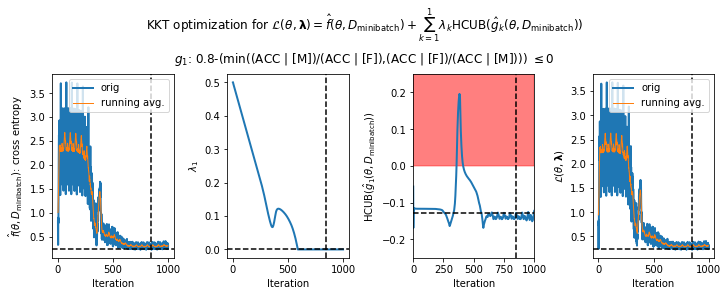

In [60]:
f='/content/logs/candidate_selection_log0.p'
sol_dict = load_pickle(f)
fig=plot_gradient_descent(sol_dict,primary_objective_name='cross entropy',plot_running_avg=True)

## Run a Seldonian Experiment

**Note:** Running the following experiments is compute-intensive on the CPU. The experiments library is parallelized across multiple CPUs to speed up the computation. However, free-tier Colab Notebooks such as the default one you may be using lack the number and quality of CPUs for running the experiments in a reasonable amount of time. To avoid having you spend hours waiting for the experiments to finish, we have pre-populated the results of running the experiments. As a result, when you run the code below, it will not run the engine for each of the trials. Instead, it will recognize that the file from running each trial already exists and move on to the plotting step. However, you would use the same code to actually run the experiments if those pre-populated files did not exist. If you want to run these experiments yourself in full, we recommend using a machine with at least 4 CPUs. For reference, on a Mac M1 with 7 CPU cores the experiment takes between between 5 and 10 minutes to complete. Though we have not tested this code in Google Colab PRO or PRO+ notebooks, we expect that the resources allocated in those paid-tier notebooks will be sufficient to run the full experiment.

Before we go any further, let's fetch the results that we will use to pre-populate the experiment so that we don't need to run the trials in this Colab Notebook. 

In [61]:
!wget https://github.com/seldonian-toolkit/Tutorials/raw/main/tutorial_j_results/headless_facial_gender_results.tgz

--2023-01-23 18:56:04--  https://github.com/seldonian-toolkit/Tutorials/raw/main/tutorial_j_results/headless_facial_gender_results.tgz
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/seldonian-toolkit/Tutorials/main/tutorial_j_results/headless_facial_gender_results.tgz [following]
--2023-01-23 18:56:04--  https://raw.githubusercontent.com/seldonian-toolkit/Tutorials/main/tutorial_j_results/headless_facial_gender_results.tgz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6624 (6.5K) [application/octet-stream]
Saving to: ‘headless_facial_gender_results.tgz’

headless_facial_gen 100%[=============

Unzip the tar file to extract the trials results.

In [62]:
! tar -zxvf headless_facial_gender_results.tgz

facial_recog_cnn_results/
facial_recog_cnn_results/facial_recog_cnn_results.csv
facial_recog_cnn_results/trial_data/
facial_recog_cnn_results/trial_data/data_frac_0.3300_trial_6.csv
facial_recog_cnn_results/trial_data/data_frac_1.0000_trial_3.csv
facial_recog_cnn_results/trial_data/data_frac_1.0000_trial_2.csv
facial_recog_cnn_results/trial_data/data_frac_0.3300_trial_7.csv
facial_recog_cnn_results/trial_data/data_frac_0.3300_trial_5.csv
facial_recog_cnn_results/trial_data/data_frac_1.0000_trial_0.csv
facial_recog_cnn_results/trial_data/data_frac_1.0000_trial_1.csv
facial_recog_cnn_results/trial_data/data_frac_0.3300_trial_4.csv
facial_recog_cnn_results/trial_data/data_frac_0.3300_trial_0.csv
facial_recog_cnn_results/trial_data/data_frac_1.0000_trial_5.csv
facial_recog_cnn_results/trial_data/data_frac_1.0000_trial_4.csv
facial_recog_cnn_results/trial_data/data_frac_0.3300_trial_1.csv
facial_recog_cnn_results/trial_data/data_frac_0.3300_trial_3.csv
facial_recog_cnn_results/trial_data/da

In [63]:
ls

age_gender.csv                      labels.pkl
age_gender.zip                      logs/
facial_gender_labels.pkl            qsa_fullmodel_results/
facial_gender_latent_features.pkl   qsa_results/
facial_recog_cnn_results/           sample_data/
features.pkl                        spec.pkl
headless_facial_gender_results.tgz


In [64]:
import os
from experiments.generate_plots import SupervisedPlotGenerator
from sklearn.metrics import log_loss,accuracy_score


pip install simglucose


pip install fairlearn==0.7.0



In [65]:
# Parameter setup
include_legend = True
performance_metric = 'Accuracy'
model_label_dict = {
  'qsa':'CNN (QSA on head only)',
  'qsa_fullmodel':'CNN (QSA on full model)',
  'facial_recog_cnn': 'full CNN (no constraints)'}

n_trials = 10
data_fracs = [0.001,0.005,0.01,0.1,0.33,0.66] 
batch_epoch_dict = {
  0.001:[24,50],
  0.005:[119,50],
  0.01:[237,75],
  0.1:[237,30],
  0.33:[237,20],
  0.66:[237,10],
  1.0: [237,10]
}
n_workers = 1
results_dir = '.'
verbose=False
os.makedirs(results_dir,exist_ok=True)

In [66]:
# Use entire original dataset as ground truth for test set
dataset = spec.dataset
test_features = dataset.features
test_labels = dataset.labels

In [67]:
# Setup performance evaluation functions and kwargs 
def perf_eval_fn(y_pred,y,**kwargs):
  if performance_metric == 'log_loss':
    return log_loss(y,y_pred)
  elif performance_metric == 'Accuracy':
    return accuracy_score(y,y_pred > 0.5)

In [68]:
perf_eval_kwargs = {
  'X':test_features,
  'y':test_labels,
  'device':cpu_device,
  'eval_batch_size':2000
  }

In [69]:
# Use default constraint eval function (don't need to set anything for that)
# Define kwargs to pass the the constraint eval function
constraint_eval_kwargs = {
  'eval_batch_size':2000
  }

In [70]:
# Make the plot generator
plot_generator = SupervisedPlotGenerator(
		spec=spec,
		n_trials=n_trials,
		data_fracs=data_fracs,
		n_workers=n_workers,
		datagen_method='resample',
		perf_eval_fn=perf_eval_fn,
		constraint_eval_fns=[],
		constraint_eval_kwargs=constraint_eval_kwargs,
		results_dir=results_dir,
		perf_eval_kwargs=perf_eval_kwargs,
		batch_epoch_dict=batch_epoch_dict,
		)


In [71]:
# Run Seldonian experiment
plot_generator.run_seldonian_experiment(verbose=verbose)

generating resampled datasets
Saved ./resampled_dataframes/trial_0.pkl
Saved ./resampled_dataframes/trial_1.pkl
Saved ./resampled_dataframes/trial_2.pkl
Saved ./resampled_dataframes/trial_3.pkl
Saved ./resampled_dataframes/trial_4.pkl
Saved ./resampled_dataframes/trial_5.pkl
Saved ./resampled_dataframes/trial_6.pkl
Saved ./resampled_dataframes/trial_7.pkl
Saved ./resampled_dataframes/trial_8.pkl
Saved ./resampled_dataframes/trial_9.pkl
Done generating resampled datasets

Saved ./qsa_results/qsa_results.csv


In addition to the QSA files that we pre-populated, we also pre-populated the experiment results from the gender classifier example. In that example, we generated results for the QSA using the full network as the Seldonian model as well as the full network without any constraints. So we have three models to compare. Let's plot them using the Experiments library. 

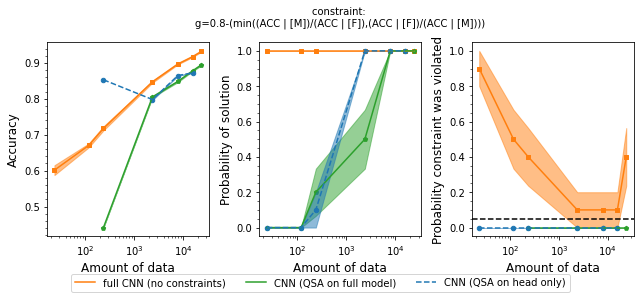

In [72]:
plot_generator.make_plots(
  model_label_dict=model_label_dict,fontsize=12,legend_fontsize=8,
  performance_label=performance_metric,
  include_legend=include_legend)

In these plots we see the accuracy (left), probability of solution (middle) and probability that the constraint was violated (right) for the three different models. The orange model is the full convolutional neural network without any constraints. It has the highest accuracy (left), but violates the constraint frequently (right). The green model is the QSA using the full network. Running an experiment with this model is very slow because all of the parameters in all layers of the network need to be trained subject to the constraint. The blue model is the model we built in this notebook. It has 256 parameters versus the 147,682 parameters (only 0.2%!) of the full network. Despite being a vastly simpler model, it  performs as well as the full network and it similarly never violates the fairness constraint.

<a name="summary"></a>
# Summary
In this tutorial, we demonstrated a strategy for efficiently applying fairness constraints to deep neural networks using the Seldonian Toolkit. The key to this method is that we don't necessarily need to re-learn most of the parameters of the network, such as basic feature-learning layers, in order to ensure a fair/safe model. We applied this technique to the <a href="https://seldonian.cs.umass.edu/Tutorials/examples/facial_recognition/">Gender bias in facial recognition example</a>, using a model consisting of only the final layer of the network in the Seldonian algorithm. We found that we were able to obtain an equally high-performing and fair model as the model trained using the entire network. 

We expect that this technique is not specific to this particular deep network, but can be applied to a range of deep learning problems. In this example, we split the model into body and head networks in such as way as to make the head the smallest possible model. It worked in this example because the final layer had enough parameters to find a solution that was high-performing and able to pass the safety test. In general, splitting at the final layer may not always work. It is possible that a different model's final layer may not have enough parameters to ensure a safe/fair model.  The choice of where to split the model, i.e., what to define as the body and the head of the network, is one we are currently exploring. It is likely dependent on the model architecture and the complexity of the constraint(s). 